In [520]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [521]:

path=str(pathlib.Path().resolve())+"/"

In [522]:
df=pd.read_csv(path+"Intel_Market.csv")
df

,Fecha,Cerrar/último,Volumen,Abrir,Alto,Bajo
0,03/04/2024,"40,33",83717980,"41,40","41,65","40,22"
1,02/04/2024,"43,94",32748360,"43,925","44,08","43,50"
2,01/04/2024,"44,52",31712590,"44,29","45,41","44,18"
3,28/03/2024,"44,17",54204190,"43,76","44,60","43,71"
4,27/03/2024,"43,77",51017830,"42,54","43,83","42,50"
...,...,...,...,...,...,...
2511,10/04/2014,"26,425",40390460,"27,01","27,09","26,36"
2512,09/04/2014,"26,98",34467000,"26,93","27,02","26,73"
2513,08/04/2014,"26,91",56564370,"26,36","26,98","26,35"
2514,07/04/2014,"26,485",49693490,"26,30","26,74","26,20"


In [523]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y').dt.date
df = df.set_index("Fecha")
df['Cerrar/último'] = df['Cerrar/último'].str.replace(",",".").astype(np.float32)
#df = df[['Cerrar/último']].rolling(7).mean().dropna()
df=df[['Cerrar/último']]

,Fecha,Cerrar/último
0,2024-04-03,40.330002
1,2024-04-02,43.939999
2,2024-04-01,44.520000
3,2024-03-28,44.169998
4,2024-03-27,43.770000
...,...,...
2511,2014-04-10,26.424999
2512,2014-04-09,26.980000
2513,2014-04-08,26.910000
2514,2014-04-07,26.485001


In [524]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)

In [501]:
X = df
y = df[:,0]

In [502]:
X

array([[0.35414284],
       [0.43699795],
       [0.45030993],
       ...,
       [0.04613268],
       [0.03637826],
       [0.02891898]], dtype=float32)

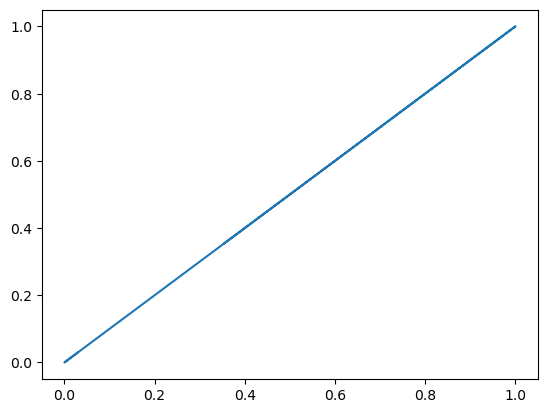

In [503]:
plt.plot(X,y)

In [504]:
from sklearn.preprocessing import LabelEncoder

l = LabelEncoder()
X = l.fit_transform(X)

c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [505]:
from sklearn.model_selection import train_test_split

value = int(len(X)*0.2)
X_train, y_train, X_test, y_test = X[value:],y[value:],X[:value],y[:value]

In [506]:
import numpy as np


X_train = np.reshape(X_train, (X_train.shape[0], 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1))

# Red de una Neurona

In [507]:
"""OJO CON EL RETURN_SEQUENCES"""
def modelo_red_recurrente_3(x_train, y_train,n_neuronas):
    
    # return_sequences significa que solo de salida por Vector no por secuencia, lo que hará que vayan todas de vez
    model = keras.models.Sequential([
        keras.layers.SimpleRNN(n_neuronas, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(n_neuronas, return_sequences=False, input_shape=[None, 1]),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(x_train, y_train, epochs=100)
    return model

In [508]:
from sklearn.metrics import mean_squared_error


modelo = modelo_red_recurrente_3(X_train, y_train,40)
y_pred = modelo.predict(X_test)
rms = mean_squared_error(y_test, y_pred, squared=False)
print(f"rms modelo_red_recurrente_1 = {rms}")

Epoch 1/100
63/63 [==============================] - 2s 2ms/step - loss: 0.0490
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 11/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 12/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 13/100
63/63 [=================

c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\diego.guizanlopez\AppData\Local\miniconda3\envs\deep-learning\Lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


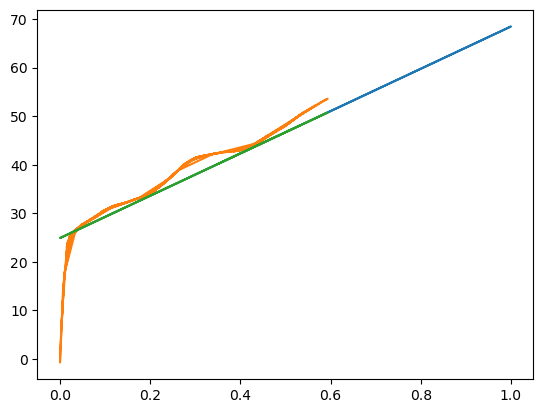

In [509]:
plt.plot(l.inverse_transform(X_train),scaler.inverse_transform(np.reshape(y_train, (y_train.shape[0], 1))))
plt.plot(l.inverse_transform(X_test),scaler.inverse_transform(y_pred))
plt.plot(l.inverse_transform(X_test),scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1))))